# Machine Learning Classification of images using Histogram of Oriented Gradients (HoG), Local Binary Patterns (LBP) and their combination Feature Extractors respectively with Random Forest Classifiers Seed Value 7

Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)

import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from skimage.color import rgb2gray
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils, to_categorical, plot_model

Using TensorFlow backend.
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anacon

## Introduction

This notebook contains the code for image classification using classical Machine Learning with Local Binary Patterns (LBP), Histogram of Oriented Gradients (HOG) and their combination respectively combined with a Random Forest (RF) Classifier. A new *random_state* or *seed* value of 7 is used in determining the data splits.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed. Many Machine Learning algorithms may perform badly if the features do not appear to be standard normally distributed data i.e. a Gaussian with unit variance and mean of zero. Hence the features are standardised/normalised.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

(224, 224, 6, 1440)


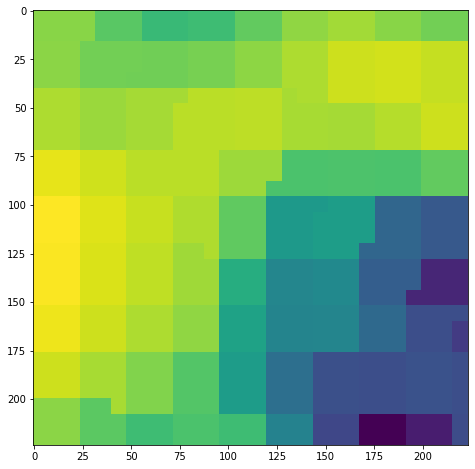

In [3]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

#img = ((np.clip(X[:,:,2,0],0,255))).astype('uint8')
img = X[:,:,2,0]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [4]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [5]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


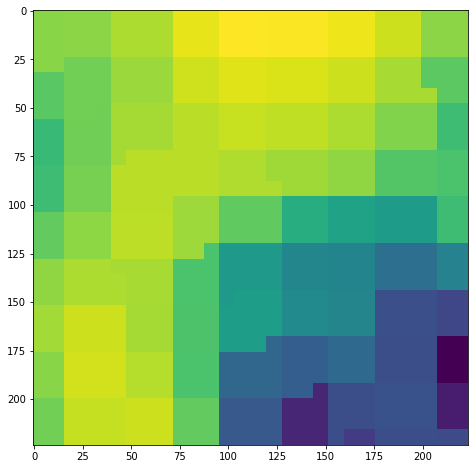

In [6]:
#img = ((np.clip(X[:,:,2,0],0,255))).astype('uint8')
img = X[0,2,:,:]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [7]:
#Scale the disp, ph and coh bands to 0 to 255 so on same scale as RGB data
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
#print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

#HoG descriptor does not need the band data to be scaled. This scaling is causing negative values to go to 0.
#X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
#print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.0 -3.1403708457946777


In [9]:
X[0,:,:,2],

(array([[-1.68371052e-02, -1.68371052e-02, -1.68371052e-02, ...,
         -1.71945747e-02, -1.71945747e-02, -1.71945747e-02],
        [-2.46855569e+00, -2.46855569e+00, -2.46855569e+00, ...,
         -2.40978551e+00, -2.40978551e+00, -2.40978551e+00],
        [ 7.76160240e-01,  7.76160240e-01,  7.76160240e-01, ...,
          7.49362648e-01,  7.49362648e-01,  7.49362648e-01],
        [ 1.54000000e+02,  1.54000000e+02,  1.54000000e+02, ...,
          1.41000000e+02,  1.41000000e+02,  1.41000000e+02],
        [ 1.66000000e+02,  1.66000000e+02,  1.66000000e+02, ...,
          1.60000000e+02,  1.60000000e+02,  1.60000000e+02],
        [ 1.78000000e+02,  1.78000000e+02,  1.78000000e+02, ...,
          1.58000000e+02,  1.58000000e+02,  1.58000000e+02]]),)

(1440, 6, 224, 224)


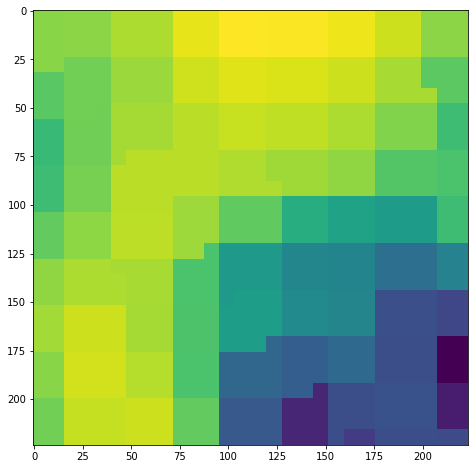

In [10]:
#Reshape to Keras desired shape
#X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

#Clip image to make it brighter, convert to 0 to 255
#img = ((np.clip(X[0,:,:,2],0,255))).astype('int')
img = X[0,2,:,:]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [11]:
#Preprocessing of images, divide by 255, not for ResNet
#X[:,:,:,0:3]=X[:,:,:,0:3]/255
#X[:,:,:,3:6]=X[:,:,:,3:6]/255
#print('max, min', np.max(X), np.min(X))

## Classifier

The classifiers are implemented below.

In [12]:
#Setup single models
def singleModel(X_features_train_val, X_features_test, y_train, y_val, y_test, train_index, val_index, 
                single_model_name_str, results_arr, clf):
    
    print(single_model_name_str)
    X_train = X_features_train_val[train_index].copy()
    X_val = X_features_train_val[val_index].copy()
    X_test = X_features_test.copy()
    print('Train: ', X_train.shape, 'Validation:', X_val.shape, 'Test:', X_test.shape)         

    clf.fit(X_train, y_train)
    #preds = clf.predict_proba(X_val)  #For SVC the predict_proba uses Planck's thingy which can be wrong, 
    #set probability to true to use predict_proba
    #preds = clf.decision_function(X_val)
    #print(preds.shape, preds)
    #print('np.argmax(predsprobs, axis=1', np.argmax(preds, axis=1))
    preds = clf.predict(X_val)
    #print('preds rounded', preds.shape, np.round(preds,2))
    
    #val_acc = round(accuracy_score(y_val, np.round(np.argmax(preds, axis=1)))*100, 2)
    val_acc = round(accuracy_score(y_val, preds)*100, 2)

    print('Validation score of ' + single_model_name_str + ' model: ', val_acc, '%')
    
    print('Grid search has completed. \n Mean cross-validated score of the best estimator is:', clf.best_score_*100)
    print('The best parameters are: ', clf.best_params_, '\n')
    results_arr.append(clf.best_params_)
    
    results_arr.append(val_acc)      
    #test_preds = clf.decision_function(X_test)
    #test_preds = clf.predict_proba(X_test)
    #test_acc = round(accuracy_score(y_test.copy(), np.round(np.argmax(test_preds,axis=1)))*100, 2)
    test_preds = clf.predict(X_test)
    test_acc = round(accuracy_score(y_test.copy(), test_preds)*100, 2)
    print('Testing Accuracy on totally unseen data of ' + single_model_name_str + ' model: ', test_acc, '%')
    results_arr.append(test_acc)     
    #results_arr = evaluator(np.round(np.argmax(test_preds,axis=1)), y_test.copy(), results_arr)
    results_arr = evaluator(test_preds, y_test.copy(), results_arr)
    del X_train, X_val, X_test, y_train
    
    return results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(X_features_train_val, X_features_test):
    X_ensemble_features_train_val = combiner(X_features_train_val)
    del X_features_train_val
    X_ensemble_features_test = combiner(X_features_test)
    del X_features_test
    return X_ensemble_features_train_val, X_ensemble_features_test

def combiner(features):
    for i in range(len(features)):
        if i==0:
            combined_features=features[i]
        if i !=0:
            combined_features=np.hstack((combined_features,features[i][:,1:]))
    return combined_features

In [13]:
#Function to train model 
def trainModel(X_histoOfG_features_train_val, X_histoOfG_features_test, y_train_val, y_test, 
                        X_locBinPat_features_train_val, X_locBinPat_features_test):

    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=7)
    sss.get_n_splits(X_histoOfG_features_train_val, y_train_val)

    single_model_name = ['HoG RF', 'LBP RF',]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Best Param', 'Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    ensemble_names = ['HoG + LBP RF',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
      
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []

    #param_grid_logreg = dict(logisticregression__C=[0.001, 0.0005, 0.0001,])
    #param_grid_svm = dict(svc__C=[0.001, 0.01, 0.1, ], svc__kernel=['linear'])
    #param_grid_svm = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
    param_grid_rf = dict(randomforestclassifier__n_estimators=[100, 150, 200, 250, 300],) 
                         #randomforestclassifier__max_features=[10, 20, 30])
        
    #refit=True means at end it will train the best parameters on all the data and tune the hyperparameters to it
    #pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000))
    #for SVC prob=True to use predict_proba but can have incorrect results rather set to false and use decision_function
    #pipe_svm = make_pipeline(StandardScaler(), svm.SVC( probability=True, max_iter=1000,))
    #pipe_svm = make_pipeline(StandardScaler(), LinearSVC(max_iter=1000,))
    pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier())
    print('pipe', pipe_rf)
    clf = []
    
    #for i in range(3):
    #clf.append(GridSearchCV(pipe_logreg, param_grid=param_grid_logreg, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    clf.append(GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    clf.append(GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    #For HoG + LBP
    clf.append(GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    #print(clf)
    
    counter = 0
    for train_index, val_index in sss.split(X_histoOfG_features_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('\n' + 'Counter: ', counter,)
        temp_time = time.time()
        results_arr.append(counter)
        print(datetime.now())
        print('Time: ', time.time()-temp_time)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        # Model 1 Histo of Grads
        results_arr = singleModel(X_histoOfG_features_train_val.copy(), X_histoOfG_features_test.copy(), y_train.copy(),
                            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, clf[0])
        
        # Model 2 llocal Binary Pattern
        results_arr = singleModel(X_locBinPat_features_train_val.copy(), X_locBinPat_features_test.copy(), y_train.copy(), 
                            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, clf[1])
        #Ensembling
        # Ensemble 1 = Models 1 + 2, Histo of Grads +LBP
        X_ens1_features_train_val = [X_histoOfG_features_train_val.copy(), X_locBinPat_features_train_val.copy()]
        X_ens1_features_test = [X_histoOfG_features_test.copy(), X_locBinPat_features_test.copy()]
        X_ens1_features_train_val, X_ens1_features_test = ensembler(X_ens1_features_train_val, X_ens1_features_test,)
        results_arr = singleModel(X_ens1_features_train_val, X_ens1_features_test, y_train.copy(),
                        y_val.copy(), y_test.copy(), train_index, val_index, ensemble_names[0], results_arr, clf[2])        

        del X_ens1_features_train_val, X_ens1_features_test,
        
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        #clear_session()
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    return results_data

In [14]:
def histoOfOrientedGRadients(img, multichannel):
    #plt.imshow(img)
    #plt.savefig('\model\\' +'g.png')
    #Need to resize to ratio 1:2 for HoG Descriptor
    img = resize(img, (224, 112))
    fd, hog_img = hog(img, orientations=9, pixels_per_cell=(8,8), 
            cells_per_block=(2,2), visualize=True, multichannel=multichannel)
    fd = fd/fd.sum()
    hog_img = hog_img/hog_img.sum()
    #plt.imshow(hog_img)
    #plt.savefig('\model\\' +'hog.png') 
    return fd

def locBinaryPattern(img):
    img_gray = rgb2gray(img)

    #plt.imshow(img_gray)
    #plt.savefig('\model\\' +'orig.png') 
    
    rad = 3
    no_points = 8*rad
    lbp = local_binary_pattern(img_gray, no_points, rad, method='uniform')
    histo, bins = np.histogram(lbp)
    histo = histo/np.sum(histo)
    #plt.imshow(lbp)
    #plt.savefig('\model\\' +'lbp.png') 
    return histo

#Extract Features
def featureExtractor(model, X_band, X_rgb):
    #float32 gives faster speed and negligible loss of precision
    X_band = X_band.astype('float32')
    X_rgb = X_rgb.astype('float32')
    
    #HoG
    if model=='HoG':
        #HoG features are 12636
        hog_start = time.time()
        print('Histo of Oriented Gradients Starting: ', hog_start, '\n', datetime.now())
        features_1 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_2 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_3 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_4 = np.zeros((X_rgb.shape[0],12636), dtype='float32')
        for i in range(X_band.shape[0]):
            features_1[i,:] = histoOfOrientedGRadients(X_band[i,0,:,:], False) #Disp, phase and coherence 
            features_2[i,:] = histoOfOrientedGRadients(X_band[i,1,:,:], False) #Disp, phase and coherence
            features_3[i,:] = histoOfOrientedGRadients(X_band[i,2,:,:], False) #Disp, phase and coherence
        print('Histo of Oriented Gradients features_1 shape \n', features_1.shape)
        print('Histo of Oriented Gradients features_2 shape \n', features_2.shape)
        print('Histo of Oriented Gradients features_3 shape \n', features_3.shape)
        for i in range(X_rgb.shape[0]):
            features_4[i,:] = histoOfOrientedGRadients(X_rgb[i,:,:,:], True) #RGB 3 band image
        print('Histo of Oriented Gradients features_4 shape \n', features_4.shape)
        hog_end = hog_start - time.time()
        print('Histo of Oriented Gradients features end: ', hog_end, '\n', datetime.now() )
    elif model=='LBP':
        lbp_start = datetime.now()
        print('LBP Feature Extraction Start ', lbp_start)
        #LBP features are 26
        features_1 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_2 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_3 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_4 = np.zeros((X_rgb.shape[0],10), dtype='float32')        

        for i in range(X_band.shape[0]):
            features_1[i,:] = locBinaryPattern(X_band[i,0,:,:]) #Disp, phase and coherence
            features_2[i,:] = locBinaryPattern(X_band[i,1,:,:]) #Disp, phase and coherence
            features_3[i,:] = locBinaryPattern(X_band[i,2,:,:]) #Disp, phase and coherence
                
        for i in range(X_rgb.shape[0]):
            features_4[i,:] = locBinaryPattern(X_rgb[i,:,:,:]) #RGB 3 band image
        print('LBP features_1 shape \n', features_1.shape)
        print('LBP features_2 shape \n', features_2.shape)
        print('LBP features_3 shape \n', features_3.shape)
        print('LBP features_4 shape \n', features_4.shape)
        
        print('LBP Feature Extraction end: ', datetime.now())
    del X_band, X_rgb
    
    #For HoG you would get a 1D vector so below might not be necessary
    X_feat = np.hstack((features_1,features_2, features_3, features_4))
    del features_1, features_2, features_3, features_4
    return X_feat

In [15]:
print(datetime.now())
start = time.time()
print('X, y shapes: ', X.shape, y.shape)

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)
    print('Train-Test Split: ', datetime.now())
    
    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    X_band_train_val = X_train_val[:,0:3,:,:].copy()
    X_rgb_train_val = X_train_val[:,3:6,:,].copy()
    X_band_test = X_test[:,0:3,:,:].copy()
    X_rgb_test = X_test[:,3:6,:,:].copy()
    
    #Image preprocessing EfficientNet B4
    image_size = 224
        
    del X_train_val, X_test
       
    model_str = 'HoG'
    # to speedup debugging and testing use: model_str = 'LBP'
    print("\n Generating Histogram of Oriented Gradients features \n")
    X_histoOfG_features_train_val = featureExtractor(model_str, X_band_train_val.copy(), X_rgb_train_val.copy())
    X_histoOfG_features_test = featureExtractor(model_str, X_band_test.copy(), X_rgb_test.copy())
    #clear_session()

    model_str = 'LBP'
    print("\n Generating Local Binary Pattern features \n")
    X_locBinPat_features_train_val = featureExtractor(model_str, X_band_train_val.copy(), X_rgb_train_val.copy())
    X_locBinPat_features_test = featureExtractor(model_str, X_band_test.copy(), X_rgb_test.copy())
    #clear_session()
    
    del X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test
    
    results = trainModel(X_histoOfG_features_train_val, X_histoOfG_features_test, y_train_val, y_test, 
                        X_locBinPat_features_train_val, X_locBinPat_features_test)

    del X_histoOfG_features_train_val, X_histoOfG_features_test, X_locBinPat_features_train_val, 
    X_locBinPat_features_test, y_train_val, y_test 
    
#Save results to CSV
results.to_csv('./model/' + 'ML_HoG_LBP_RF_Seed_7_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print('Total running time (h): %.2f hours' % (elapsed/3600.0))
print(datetime.now())

2021-08-20 20:58:40.890165
X, y shapes:  (1440, 6, 224, 224) (1440,)
Train-Test Split:  2021-08-20 20:58:40.893037

 Generating Histogram of Oriented Gradients features 

Histo of Oriented Gradients Starting:  1629485927.4755888 
 2021-08-20 20:58:47.475593
Histo of Oriented Gradients features_1 shape 
 (1152, 12636)
Histo of Oriented Gradients features_2 shape 
 (1152, 12636)
Histo of Oriented Gradients features_3 shape 
 (1152, 12636)
Histo of Oriented Gradients features_4 shape 
 (1152, 12636)
Histo of Oriented Gradients features end:  -976.4418714046478 
 2021-08-20 21:15:03.917462
Histo of Oriented Gradients Starting:  1629486904.1188488 
 2021-08-20 21:15:04.118851
Histo of Oriented Gradients features_1 shape 
 (288, 12636)
Histo of Oriented Gradients features_2 shape 
 (288, 12636)
Histo of Oriented Gradients features_3 shape 
 (288, 12636)
Histo of Oriented Gradients features_4 shape 
 (288, 12636)
Histo of Oriented Gradients features end:  -245.23283553123474 
 2021-08-20 21:1

Train:  (921, 50544) Validation: (231, 50544) Test: (288, 50544)
Validation score of HoG RF model:  59.31 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 61.83783783783784
The best parameters are:  {'randomforestclassifier__n_estimators': 150} 

Testing Accuracy on totally unseen data of HoG RF model:  62.15 %
F1 score is:  0.62
Recall score is:  0.62
Precision score is:  0.62
Confusion matrix: 
 [[84 60]
 [49 95]]
From the confusion matrix above there are 84 true negatives and 60 false positives.
There are 49 false negatives and 95 true positives. 

LBP RF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP RF model:  69.26 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 72.75675675675676
The best parameters are:  {'randomforestclassifier__n_estimators': 200} 

Testing Accuracy on totally unseen data of LBP RF model:  70.49 %
F1 score is:  0.7
Recall score is:  0.71
Precision score is: 

Train:  (921, 50544) Validation: (231, 50544) Test: (288, 50544)
Validation score of HoG RF model:  56.28 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 61.72972972972973
The best parameters are:  {'randomforestclassifier__n_estimators': 200} 

Testing Accuracy on totally unseen data of HoG RF model:  60.76 %
F1 score is:  0.61
Recall score is:  0.61
Precision score is:  0.61
Confusion matrix: 
 [[85 59]
 [54 90]]
From the confusion matrix above there are 85 true negatives and 59 false positives.
There are 54 false negatives and 90 true positives. 

LBP RF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP RF model:  72.73 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 70.5945945945946
The best parameters are:  {'randomforestclassifier__n_estimators': 200} 

Testing Accuracy on totally unseen data of LBP RF model:  70.49 %
F1 score is:  0.7
Recall score is:  0.71
Precision score is:  

Train:  (921, 50544) Validation: (231, 50544) Test: (288, 50544)
Validation score of HoG RF model:  61.47 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 61.78378378378378
The best parameters are:  {'randomforestclassifier__n_estimators': 150} 

Testing Accuracy on totally unseen data of HoG RF model:  64.24 %
F1 score is:  0.64
Recall score is:  0.64
Precision score is:  0.64
Confusion matrix: 
 [[86 58]
 [45 99]]
From the confusion matrix above there are 86 true negatives and 58 false positives.
There are 45 false negatives and 99 true positives. 

LBP RF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP RF model:  71.86 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 69.94594594594594
The best parameters are:  {'randomforestclassifier__n_estimators': 300} 

Testing Accuracy on totally unseen data of LBP RF model:  67.71 %
F1 score is:  0.68
Recall score is:  0.68
Precision score is:

Train:  (921, 50544) Validation: (231, 50544) Test: (288, 50544)
Validation score of HoG RF model:  58.01 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 63.83783783783784
The best parameters are:  {'randomforestclassifier__n_estimators': 250} 

Testing Accuracy on totally unseen data of HoG RF model:  60.76 %
F1 score is:  0.61
Recall score is:  0.61
Precision score is:  0.61
Confusion matrix: 
 [[76 68]
 [45 99]]
From the confusion matrix above there are 76 true negatives and 68 false positives.
There are 45 false negatives and 99 true positives. 

LBP RF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP RF model:  71.43 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 71.08108108108108
The best parameters are:  {'randomforestclassifier__n_estimators': 250} 

Testing Accuracy on totally unseen data of LBP RF model:  70.83 %
F1 score is:  0.71
Recall score is:  0.71
Precision score is: